## Teste Técnico - Programa Trainee triggo.ai 2025

### Other packages used in this notebook

In [36]:
# %pip install numpy
# %pip install pandas

# %pip install duckdb
# %pip install kagglehub

# %pip install matplotlib
# %pip install seaborn

# %pip install geopy

### Imports

In [37]:
import numpy as np
import pandas as pd
import duckdb
import kagglehub

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance 

# Part 1:

## Data Loading and Cleaning

This project is divided in 4 parts and each part have it's own particular questions:
- Data cleaning and modelling.
    - Importing the dataset .csv file from Kaggle ("olistbr/brazilian-ecommerce")
    - Data cleaning and normalizing
    - Creation of a relational data modelling
    - Describing each step in the data prep

### Kaggle dataset download

In [38]:
# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lucas.Batista\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2


### Reading the datasets into Pandas DataFrames

Listing all the 9 datasets and describing them:

- olist_customers_dataset.csv
    - Contains information about the customers
    - Raw column names: customer_id, customer_unique_id, customer_zip_code_prefix, customer_city and customer_state
- olist_geolocation_dataset.csv
    - Contains geolocalization information of every geolocation in the dataset
    - Raw column names: geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state
- olist_order_items_dataset.csv
    - Contains information about the customers
    - Raw column names: order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value
- olist_order_payments_dataset.csv
    - Contains information the orders payments
    - Raw column names: order_id, payment_sequential, payment_type, payment_installments, payment_value
- olist_order_reviews_dataset.csv
    - Contains information about the reviews from customers for every order
    - Raw column names: review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timest
- olist_orders_dataset.csv
    - Contains information about orders details
    - Raw column names: order_id,customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date,order_estimated_delivery_date
- olist_products_dataset
    - Contains information about products details
    - Raw column names: product_id, product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
- olist_sellers_dataset
    - Contains information about the sellers
    - Raw column names: seller_id, seller_zip_code_prefix, seller_city, seller_state
- product_category_name_translation
    - Contains name translations, wont be used in this project

![Table Diagram](<Table Diagram.png>)

### Read the olist_customers_dataset.csv into df_customers


In [39]:
dtype = {'customer_zip_code_prefix': 'string'}

df_customers = pd.read_csv(path + r"\olist_customers_dataset.csv", dtype=dtype)

df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Read the olist_geolocation_dataset.csv into df_geolocation


In [40]:
dtype = {'geolocation_zip_code_prefix': 'string'}

df_geolocation = pd.read_csv(path + r"\olist_geolocation_dataset.csv", dtype=dtype)

df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


### Read the olist_order_items_dataset.csv into df_order_items


In [41]:
parse_dates = ['shipping_limit_date']

df_order_items = pd.read_csv(path + r"\olist_order_items_dataset.csv", parse_dates=parse_dates)

df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Read the olist_order_payments_dataset.csv to df_order_payments


In [42]:
df_order_payments = pd.read_csv(path + r"\olist_order_payments_dataset.csv")

df_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Read the olist_order_reviews_dataset.csv to df_order_reviews


In [43]:
parse_dates = ['review_creation_date', 'review_answer_timestamp']

df_order_reviews = pd.read_csv(path + r"\olist_order_reviews_dataset.csv", parse_dates=parse_dates)

df_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


### Read the olist_orders_dataset.csv to df_orders


In [44]:
parse_dates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

df_orders = pd.read_csv(path + r"\olist_orders_dataset.csv", parse_dates=parse_dates)

df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


### Read the olist_products_dataset.csv to df_products


In [45]:
df_products = pd.read_csv(path + r"\olist_products_dataset.csv")

df_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


### Read the olist_sellers_dataset.csv to df_sellers


In [46]:
dtype = {'seller_zip_code_prefix': 'string'}

df_sellers = pd.read_csv(path + r"\olist_sellers_dataset.csv", dtype=dtype)

df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


# Part 2:

## Exploratory Analysis

- Exploratory analysis using SQL and Python
    - Orders volume per month and its seasonality
    - The distribution of orders delivery time
    - The relationship between delivery costs and delivery distance
    - Which are the best-selling products in revenue
    - Brazilian states with the highest average order value

### Orders volume per month and its seasonality

Here I used datetrunc to get the months of every date, then format with strftime, to get only a Month date. If datepart was used it would return an Integer instead of a String, so I prefer this way.

In [47]:
orders_per_month = duckdb.query(
                                    """
                                    SELECT 
                                        strftime(datetrunc('month', order_purchase_timestamp), '%m') AS month, 
                                        COUNT( order_id) AS count_orders 
                                    FROM df_orders 
                                    GROUP BY month 
                                    ORDER BY month
                                    """

                                ).df()

orders_per_month

,month,count_orders
0,01,8069
1,02,8508
2,03,9893
3,04,9343
4,05,10573
5,06,9412
6,07,10318
7,08,10843
8,09,4305
9,10,4959


### Months of August, May and July were the top 3 orders per months

Im using iloc to get the first and second columns

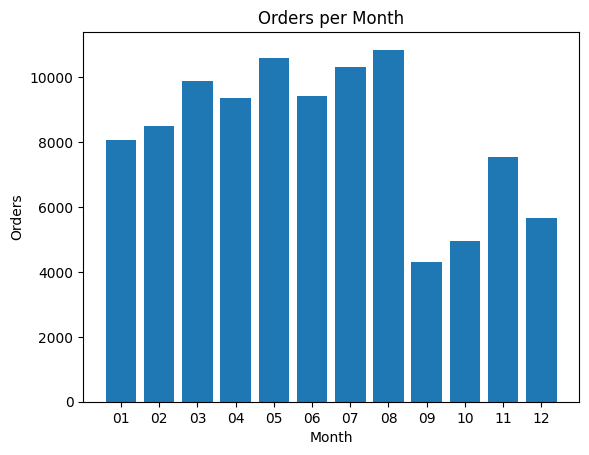

In [48]:
month = orders_per_month.iloc[:, 0]
count_orders = orders_per_month.iloc[:, 1]

plt.bar(month, count_orders)
plt.title('Orders per Month')
plt.xlabel('Month')
plt.ylabel('Orders')
plt.show()


### The Distribution of orders delivery time

To calculate the delivery time, Im using the order_delivered_customer_date as delivery time and the order_approved_at when the timer to the order be shipped

Calculating the mode of the dataset, to get the most frequent day to delivery

Selection only orders with the order_status = delivered

In [49]:
order_delivery_time = duckdb.query(
                                    """
                                    SELECT
                                        order_id, 
                                        datediff('day', order_approved_at, order_delivered_customer_date) AS day_to_delivery 
                                    FROM df_orders 
                                    WHERE order_status = 'delivered'
                                    """

                                ).df()

print('Mode: ', order_delivery_time.day_to_delivery.mode())

Mode:  0    7
Name: day_to_delivery, dtype: Int64


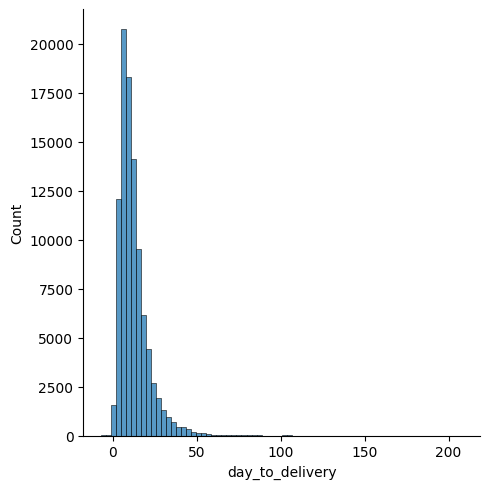

In [50]:
sns.displot(order_delivery_time, x="day_to_delivery", binwidth=3)

### SQL JOINs to get the right data from the multiple tables

- Starting with Customer table joining Geolocation table, to get the latitute and longitude from each customer
- As latitude and Longitude coulh have multiple values for each zip code, I decided to use the AVG function to get an average of each location
- Then joining Customer table with Orders table to get the order_id

In [51]:
customer_geo = duckdb.query(
"""
  SELECT
    c.customer_id,
    c.customer_zip_code_prefix,
    c.customer_city,
    c.customer_state,
    o.order_id,
    COALESCE(o.order_approved_at, o.order_purchase_timestamp) AS order_approved_at,
    o.order_delivered_customer_date,
    o.order_estimated_delivery_date,
    AVG(g.geolocation_lat) AS customer_lat,
    AVG(g.geolocation_lng) AS customer_lng
  FROM
    df_customers AS c
  INNER JOIN
    df_geolocation AS g
      ON c.customer_zip_code_prefix = g.geolocation_zip_code_prefix
      AND c.customer_city = g.geolocation_city
      AND c.customer_state = g.geolocation_state
  INNER JOIN 
    df_orders AS o
      ON c.customer_id = o.customer_id
      AND order_status = 'delivered'
  GROUP BY
    1,2,3,4,5,6,7,8
"""
).df()

customer_geo.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_lat,customer_lng
0,ee7b717223b68b96062227b4182befc7,04728,sao paulo,SP,84b534c4e6899dae169caa25fa2c887c,2018-04-24 18:18:18,2018-04-28 00:49:01,2018-05-14,-23.639488,-46.714587
1,577ece54796bd0f230d4df152b53536f,04754,sao paulo,SP,4e36ca9de4b97cb87ff2c474107c28f1,2017-11-28 02:53:42,2017-12-04 20:42:25,2017-12-12,-23.652301,-46.715364
2,cec800e76b1cc898de17926aa9e1e146,04757,sao paulo,SP,aa14b8f4567fef1be1a8912ca010f1c7,2018-08-24 21:30:16,2018-08-30 21:32:40,2018-09-10,-23.651036,-46.719642
3,41288d4a1cb5b4716c3661bb33a11a01,04711,sao paulo,SP,ee00fa5093eb96d8573403b382fb60a8,2018-07-05 16:08:58,2018-07-10 20:37:34,2018-07-25,-23.627452,-46.700916
4,d78521153aeb150f08bf0ddb3cfcba84,04720,sao paulo,SP,9f6dfdbc41dfe578aaf31edd0ba546db,2018-08-14 08:50:31,2018-08-18 15:03:48,2018-08-22,-23.636275,-46.702769


Joining the customer_geo table with df_order_items, to get some metrics and to join with df_products, to get products metrics, for usage in the freight calculation 

In [52]:

order_products = duckdb.query(
"""
  SELECT
    cg.customer_id,
    cg.customer_zip_code_prefix,
    cg.customer_city,
    cg.customer_state,
    cg.customer_lat,
    cg.customer_lng,
    cg.order_id,
    cg.order_approved_at,
    cg.order_delivered_customer_date,
    cg.order_estimated_delivery_date, 
    oi.seller_id,
    oi.product_id,
    oi.price,
    oi.freight_value,
    p.product_category_name
  FROM 
    customer_geo AS cg
  INNER JOIN   
    df_order_items AS oi
      ON cg.order_id = oi.order_id
  INNER JOIN   
    df_products AS p
      ON oi.product_id = p.product_id
"""
).df()

order_products

,customer_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,order_id,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,seller_id,product_id,price,freight_value,product_category_name
0,ee7b717223b68b96062227b4182befc7,04728,sao paulo,SP,-23.639488,-46.714587,84b534c4e6899dae169caa25fa2c887c,2018-04-24 18:18:18,2018-04-28 00:49:01,2018-05-14,a1043bafd471dff536d0c462352beb48,8c591ab0ca519558779df02023177f44,110.00,62.44,ferramentas_jardim
1,577ece54796bd0f230d4df152b53536f,04754,sao paulo,SP,-23.652301,-46.715364,4e36ca9de4b97cb87ff2c474107c28f1,2017-11-28 02:53:42,2017-12-04 20:42:25,2017-12-12,955fee9216a65b617aa5c0531780ce60,aca2eb7d00ea1a7b8ebd4e68314663af,75.00,13.08,moveis_decoracao
2,cec800e76b1cc898de17926aa9e1e146,04757,sao paulo,SP,-23.651036,-46.719642,aa14b8f4567fef1be1a8912ca010f1c7,2018-08-24 21:30:16,2018-08-30 21:32:40,2018-09-10,1835b56ce799e6a4dc4eddc053f04066,6f58f28210b611d0907de2b23c2e78a9,26.99,2.54,cama_mesa_banho
3,41288d4a1cb5b4716c3661bb33a11a01,04711,sao paulo,SP,-23.627452,-46.700916,ee00fa5093eb96d8573403b382fb60a8,2018-07-05 16:08:58,2018-07-10 20:37:34,2018-07-25,ad420dd0c4f92f8af951ac24b86d0cf5,eaeca85086b0c4f68351e52deb944e16,14.99,18.23,beleza_saude
4,d78521153aeb150f08bf0ddb3cfcba84,04720,sao paulo,SP,-23.636275,-46.702769,9f6dfdbc41dfe578aaf31edd0ba546db,2018-08-14 08:50:31,2018-08-18 15:03:48,2018-08-22,5a425cc503b39b262a847fd6212bf53b,45f59788a3a09e09ab433234d03afd2a,119.90,15.14,brinquedos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109860,17f9863585a471e9ffe77c4d4f26ecea,11750,peruibe,SP,-24.303242,-46.987183,83f0c4c6b1a3c31214ca8266dc888258,2018-01-27 00:18:24,2018-02-21 23:33:12,2018-03-09,7c67e1448b00f6e969d365cea6b010ab,3eef0cb94ba82de806bb30ab743c7655,79.99,28.96,moveis_escritorio
109861,b751fcae2274aac027b38ae2b7e8b009,12230,sao jose dos campos,SP,-23.224501,-45.887771,1daecbe2a13ab0881c418e978f1e08c1,2017-10-18 12:49:41,2017-10-19 15:32:12,2017-10-30,20d83f3ef0e6925fd74bfd59170babf7,d191e54bd50ba045ac5bc9336572886f,29.90,9.34,fashion_bolsas_e_acessorios
109862,b0122e56650079ca699d17446a11bfbb,22261,rio de janeiro,RJ,-22.957218,-43.200261,e0f7f2941ad3a817c0cdb8f90b13f0f3,2017-11-23 10:12:34,2017-12-04 17:58:04,2017-12-26,4c2b230173bb36f9b240f2b8ac11786e,10b0226d162bdc55d60c0eabf68c7021,39.90,2.83,esporte_lazer
109863,5e63d746b7b0811e6e09d7259661ca25,22735,rio de janeiro,RJ,-22.920929,-43.358465,d5bd26cb62e49fde71c09ef5039cf2f6,2018-02-27 20:30:25,2018-03-28 17:46:35,2018-04-04,7c67e1448b00f6e969d365cea6b010ab,feb4ade62e32b8d74c6f69f635057964,89.98,39.56,moveis_sala


- Joining the seller_df and the geolocation_df to get the seller localization
- Again, using the AVG function to get an average of each zip_code

In [53]:

seller_geo = duckdb.query(
"""
  SELECT
    s.seller_id,
    s.seller_zip_code_prefix,
    s.seller_city,
    s.seller_state,
    AVG(g.geolocation_lat) AS seller_lat,
    AVG(g.geolocation_lng) AS seller_lng
  FROM
    df_sellers AS s
  INNER JOIN
    df_geolocation AS g
      ON s.seller_zip_code_prefix = g.geolocation_zip_code_prefix
      AND s.seller_city = g.geolocation_city
      AND s.seller_state = g.geolocation_state
  GROUP BY
    1,2,3,4
"""
).df()

seller_geo.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,bd4431c1a8dfa744b59e1e2a8bc99b9e,20761,rio de janeiro,RJ,-22.870098,-43.297218
1,abe42c5d03695b4257b5c6cbf4e6784e,21235,rio de janeiro,RJ,-22.837912,-43.322271
2,fad44952713764836814be105382aee5,21340,rio de janeiro,RJ,-22.871018,-43.356845
3,634964b17796e64304cadf1ad3050fb7,21840,rio de janeiro,RJ,-22.868364,-43.469232
4,68f86ba270525243e68ae74044f992b9,21941,rio de janeiro,RJ,-22.833834,-43.248857


- Joining the order_products with the seller_geo df to get the sellers data
- Joining order_products with the df_order_reviews, and get the review score
- Use the coalesce function to give a 0 to the review_score in case it was NULL (the customer didnt review)

In [54]:
master_table = duckdb.query(
"""
  SELECT
    op.order_id,
    coalesce(r.review_score,0) AS review_score,
    order_approved_at,
    order_delivered_customer_date,
    order_estimated_delivery_date, 

    product_id,
    price,
    freight_value,
    product_category_name,

    customer_id,
    customer_zip_code_prefix,
    customer_city,
    customer_state,
    customer_lat,
    customer_lng,

    s.seller_id,
    s.seller_zip_code_prefix,
    s.seller_city,
    s.seller_state,
    seller_lat,
    seller_lng
  FROM
    order_products AS op
  INNER JOIN
    seller_geo AS s
      ON op.seller_id = s.seller_id
  LEFT JOIN
    df_order_reviews AS r
      ON op.order_id = r.order_id
"""
).df()

master_table

,order_id,review_score,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,product_id,price,freight_value,product_category_name,customer_id,...,customer_city,customer_state,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
0,30cbc667959773c36d34c2ce5e02b4ac,3,2017-11-24 09:33:36,2017-12-05 14:46:08,2017-12-27,060890b1af8cc031e9dde49cf544f884,89.58,48.07,automotivo,ef913faf232d3ef42bee90bc490c2ab6,...,atalaia,AL,-9.506694,-36.014881,8581055ce74af1daba164fdbd55a40de,07112,guarulhos,SP,-23.468704,-46.516142
1,767cc814433df2750747896ffc066766,4,2018-06-28 01:15:12,2018-07-09 15:18:38,2018-08-03,7a3bc1b5f3ad201ecd5d03d51d34bedd,336.00,53.07,beleza_saude,2edc6f92f35d994f26752db0fd1f5727,...,santana do mundau,AL,-9.165584,-36.218830,7e1fb0a3ebfb01ffb3a7dae98bf3238d,14403,franca,SP,-20.553624,-47.387359
2,ec8e9a10b613682c45e614fd392bb666,5,2017-05-04 11:10:18,2017-05-16 08:33:55,2017-06-16,76ad24d8518857df0f3dc45b2f5faf2d,64.00,20.90,beleza_saude,2986e0dcdf8b36c8fb8a591504ddb0aa,...,matriz de camaragibe,AL,-9.156551,-35.532929,44073f8b7e41514de3b7815dd0237f4f,71070,brasilia,DF,-15.836052,-47.951014
3,8cf0f8036fecc83aff5f07f4b5a4db55,3,2018-04-17 14:11:30,2018-05-08 00:27:34,2018-05-16,aca2eb7d00ea1a7b8ebd4e68314663af,69.90,0.00,moveis_decoracao,500d19ce7db9f10540bb6a251379cc6f,...,joao pessoa,PB,-7.068220,-34.842438,955fee9216a65b617aa5c0531780ce60,04782,sao paulo,SP,-23.691093,-46.703699
4,891d3c75ab79901d8faa6437f1cfeb43,5,2017-07-24 16:55:13,2017-08-15 16:16:06,2017-08-25,b931645cdc2d9868f01544e8db63f5ab,69.00,38.03,ferramentas_jardim,b038e0260259f784a738835953f32c62,...,joao pessoa,PB,-7.122291,-34.877285,b14db04aa7881970e83ffa9426897925,18048,sorocaba,SP,-23.536890,-47.469687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107488,5989e29098198898f9fe8490e6040c6b,0,2018-04-11 21:30:22,2018-04-14 01:10:50,2018-04-27,4e674f56be3a9b8c94fafaa44cbba42e,49.99,13.43,ferramentas_jardim,0be456ed130a857046b0b296e0f9badf,...,sao paulo,SP,-23.592466,-46.602445,a414555ce331b8c8aea4a9cb8395194d,03638,sao paulo,SP,-23.528455,-46.541506
107489,3dfb50022bb703d781966370133ed7a5,0,2018-02-07 00:30:42,2018-02-27 02:52:21,2018-03-12,e3e6af2b9a779d64b3589a5b56102d16,39.00,18.89,moveis_decoracao,e0ef4d2528118e7e4798cfac790e0afe,...,olinda,PE,-7.962007,-34.851144,5343d0649eca2a983820bfe93fc4d17e,09270,santo andre,SP,-23.640609,-46.494645
107490,ea0aecca2de1f337e8a16c457f407eb3,0,2018-03-01 16:21:33,2018-03-21 19:24:55,2018-03-19,1d4de03a6141ce2a2ae5a97f51cabb37,199.00,12.89,cama_mesa_banho,65893fec38e42fb5882899f961989c9c,...,sao paulo,SP,-23.473028,-46.647485,7ad32824caee82087b3e2e5f33b1bf32,14940,ibitinga,SP,-21.757321,-48.829744
107491,0996d6fb4402593986c6b1541bfcb4cc,0,2018-05-03 21:50:54,2018-05-18 14:24:57,2018-05-14,ffc9caf33e2d1e9f44e3e06da19085f7,199.89,12.02,beleza_saude,f1de7e62c59c215f024ba7de9744fba5,...,sao paulo,SP,-23.481601,-46.493609,b18dc380845b24038cfc48006478f099,09951,diadema,SP,-23.689006,-46.590933


In [55]:
delivery_costs = duckdb.query(
"""
  SELECT
    order_id,

    product_id,
    freight_value,    
    product_category_name,

    customer_id,
    customer_zip_code_prefix,
    customer_lat,
    customer_lng,

    seller_id,
    seller_zip_code_prefix,
    seller_lat,
    seller_lng
  FROM
    master_table 
"""
).df()

delivery_costs

,order_id,product_id,freight_value,product_category_name,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_lat,seller_lng
0,30cbc667959773c36d34c2ce5e02b4ac,060890b1af8cc031e9dde49cf544f884,48.07,automotivo,ef913faf232d3ef42bee90bc490c2ab6,57690,-9.506694,-36.014881,8581055ce74af1daba164fdbd55a40de,07112,-23.468704,-46.516142
1,767cc814433df2750747896ffc066766,7a3bc1b5f3ad201ecd5d03d51d34bedd,53.07,beleza_saude,2edc6f92f35d994f26752db0fd1f5727,57840,-9.165584,-36.218830,7e1fb0a3ebfb01ffb3a7dae98bf3238d,14403,-20.553624,-47.387359
2,ec8e9a10b613682c45e614fd392bb666,76ad24d8518857df0f3dc45b2f5faf2d,20.90,beleza_saude,2986e0dcdf8b36c8fb8a591504ddb0aa,57910,-9.156551,-35.532929,44073f8b7e41514de3b7815dd0237f4f,71070,-15.836052,-47.951014
3,8cf0f8036fecc83aff5f07f4b5a4db55,aca2eb7d00ea1a7b8ebd4e68314663af,0.00,moveis_decoracao,500d19ce7db9f10540bb6a251379cc6f,58035,-7.068220,-34.842438,955fee9216a65b617aa5c0531780ce60,04782,-23.691093,-46.703699
4,891d3c75ab79901d8faa6437f1cfeb43,b931645cdc2d9868f01544e8db63f5ab,38.03,ferramentas_jardim,b038e0260259f784a738835953f32c62,58013,-7.122291,-34.877285,b14db04aa7881970e83ffa9426897925,18048,-23.536890,-47.469687
...,...,...,...,...,...,...,...,...,...,...,...,...
107488,5989e29098198898f9fe8490e6040c6b,4e674f56be3a9b8c94fafaa44cbba42e,13.43,ferramentas_jardim,0be456ed130a857046b0b296e0f9badf,04213,-23.592466,-46.602445,a414555ce331b8c8aea4a9cb8395194d,03638,-23.528455,-46.541506
107489,3dfb50022bb703d781966370133ed7a5,e3e6af2b9a779d64b3589a5b56102d16,18.89,moveis_decoracao,e0ef4d2528118e7e4798cfac790e0afe,53080,-7.962007,-34.851144,5343d0649eca2a983820bfe93fc4d17e,09270,-23.640609,-46.494645
107490,ea0aecca2de1f337e8a16c457f407eb3,1d4de03a6141ce2a2ae5a97f51cabb37,12.89,cama_mesa_banho,65893fec38e42fb5882899f961989c9c,02443,-23.473028,-46.647485,7ad32824caee82087b3e2e5f33b1bf32,14940,-21.757321,-48.829744
107491,0996d6fb4402593986c6b1541bfcb4cc,ffc9caf33e2d1e9f44e3e06da19085f7,12.02,beleza_saude,f1de7e62c59c215f024ba7de9744fba5,03828,-23.481601,-46.493609,b18dc380845b24038cfc48006478f099,09951,-23.689006,-46.590933


### Using the lib GeoPY its possible to calculate the distance between two point using the latitude and longitude

In [56]:
def calculate_distance(row):
    customer_location = (row['customer_lat'], row['customer_lng'])
    seller_location = (row['seller_lat'], row['seller_lng'])
    return distance.distance(customer_location, seller_location).km


delivery_costs['delivery_distance'] = delivery_costs.apply(calculate_distance, axis=1)

delivery_costs

,order_id,product_id,freight_value,product_category_name,customer_id,customer_zip_code_prefix,customer_lat,customer_lng,seller_id,seller_zip_code_prefix,seller_lat,seller_lng,delivery_distance
0,30cbc667959773c36d34c2ce5e02b4ac,060890b1af8cc031e9dde49cf544f884,48.07,automotivo,ef913faf232d3ef42bee90bc490c2ab6,57690,-9.506694,-36.014881,8581055ce74af1daba164fdbd55a40de,07112,-23.468704,-46.516142,1906.966380
1,767cc814433df2750747896ffc066766,7a3bc1b5f3ad201ecd5d03d51d34bedd,53.07,beleza_saude,2edc6f92f35d994f26752db0fd1f5727,57840,-9.165584,-36.218830,7e1fb0a3ebfb01ffb3a7dae98bf3238d,14403,-20.553624,-47.387359,1739.681834
2,ec8e9a10b613682c45e614fd392bb666,76ad24d8518857df0f3dc45b2f5faf2d,20.90,beleza_saude,2986e0dcdf8b36c8fb8a591504ddb0aa,57910,-9.156551,-35.532929,44073f8b7e41514de3b7815dd0237f4f,71070,-15.836052,-47.951014,1537.983761
3,8cf0f8036fecc83aff5f07f4b5a4db55,aca2eb7d00ea1a7b8ebd4e68314663af,0.00,moveis_decoracao,500d19ce7db9f10540bb6a251379cc6f,58035,-7.068220,-34.842438,955fee9216a65b617aa5c0531780ce60,04782,-23.691093,-46.703699,2234.023937
4,891d3c75ab79901d8faa6437f1cfeb43,b931645cdc2d9868f01544e8db63f5ab,38.03,ferramentas_jardim,b038e0260259f784a738835953f32c62,58013,-7.122291,-34.877285,b14db04aa7881970e83ffa9426897925,18048,-23.536890,-47.469687,2260.979851
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107488,5989e29098198898f9fe8490e6040c6b,4e674f56be3a9b8c94fafaa44cbba42e,13.43,ferramentas_jardim,0be456ed130a857046b0b296e0f9badf,04213,-23.592466,-46.602445,a414555ce331b8c8aea4a9cb8395194d,03638,-23.528455,-46.541506,9.432183
107489,3dfb50022bb703d781966370133ed7a5,e3e6af2b9a779d64b3589a5b56102d16,18.89,moveis_decoracao,e0ef4d2528118e7e4798cfac790e0afe,53080,-7.962007,-34.851144,5343d0649eca2a983820bfe93fc4d17e,09270,-23.640609,-46.494645,2134.036835
107490,ea0aecca2de1f337e8a16c457f407eb3,1d4de03a6141ce2a2ae5a97f51cabb37,12.89,cama_mesa_banho,65893fec38e42fb5882899f961989c9c,02443,-23.473028,-46.647485,7ad32824caee82087b3e2e5f33b1bf32,14940,-21.757321,-48.829744,293.987990
107491,0996d6fb4402593986c6b1541bfcb4cc,ffc9caf33e2d1e9f44e3e06da19085f7,12.02,beleza_saude,f1de7e62c59c215f024ba7de9744fba5,03828,-23.481601,-46.493609,b18dc380845b24038cfc48006478f099,09951,-23.689006,-46.590933,25.026731


### Calculating the relationship between freigth cost and distance

In [57]:
cents_per_km = duckdb.query(
"""
  SELECT
    order_id,
    product_id,
    product_category_name,
    freight_value,
    delivery_distance,
    freight_value / delivery_distance AS price_per_km  
  FROM
    delivery_costs 
"""
).df()

cents_per_km

,order_id,product_id,product_category_name,freight_value,delivery_distance,price_per_km
0,30cbc667959773c36d34c2ce5e02b4ac,060890b1af8cc031e9dde49cf544f884,automotivo,48.07,1906.966380,0.025208
1,767cc814433df2750747896ffc066766,7a3bc1b5f3ad201ecd5d03d51d34bedd,beleza_saude,53.07,1739.681834,0.030506
2,ec8e9a10b613682c45e614fd392bb666,76ad24d8518857df0f3dc45b2f5faf2d,beleza_saude,20.90,1537.983761,0.013589
3,8cf0f8036fecc83aff5f07f4b5a4db55,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,0.00,2234.023937,0.000000
4,891d3c75ab79901d8faa6437f1cfeb43,b931645cdc2d9868f01544e8db63f5ab,ferramentas_jardim,38.03,2260.979851,0.016820
...,...,...,...,...,...,...
107488,5989e29098198898f9fe8490e6040c6b,4e674f56be3a9b8c94fafaa44cbba42e,ferramentas_jardim,13.43,9.432183,1.423849
107489,3dfb50022bb703d781966370133ed7a5,e3e6af2b9a779d64b3589a5b56102d16,moveis_decoracao,18.89,2134.036835,0.008852
107490,ea0aecca2de1f337e8a16c457f407eb3,1d4de03a6141ce2a2ae5a97f51cabb37,cama_mesa_banho,12.89,293.987990,0.043845
107491,0996d6fb4402593986c6b1541bfcb4cc,ffc9caf33e2d1e9f44e3e06da19085f7,beleza_saude,12.02,25.026731,0.480286


In [58]:
cents_per_km = duckdb.query(
"""
    SELECT
        order_id,
        product_id,
        product_category_name,
        freight_value,
        CASE WHEN delivery_distance < 1 THEN 1 ELSE delivery_distancE END AS delivery_distance,
        freight_value / (CASE WHEN delivery_distance < 1 THEN 1 ELSE delivery_distance END) AS price_per_km  
    FROM
        delivery_costs
"""
).df()

cents_per_km

,order_id,product_id,product_category_name,freight_value,delivery_distance,price_per_km
0,30cbc667959773c36d34c2ce5e02b4ac,060890b1af8cc031e9dde49cf544f884,automotivo,48.07,1906.966380,0.025208
1,767cc814433df2750747896ffc066766,7a3bc1b5f3ad201ecd5d03d51d34bedd,beleza_saude,53.07,1739.681834,0.030506
2,ec8e9a10b613682c45e614fd392bb666,76ad24d8518857df0f3dc45b2f5faf2d,beleza_saude,20.90,1537.983761,0.013589
3,8cf0f8036fecc83aff5f07f4b5a4db55,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,0.00,2234.023937,0.000000
4,891d3c75ab79901d8faa6437f1cfeb43,b931645cdc2d9868f01544e8db63f5ab,ferramentas_jardim,38.03,2260.979851,0.016820
...,...,...,...,...,...,...
107488,5989e29098198898f9fe8490e6040c6b,4e674f56be3a9b8c94fafaa44cbba42e,ferramentas_jardim,13.43,9.432183,1.423849
107489,3dfb50022bb703d781966370133ed7a5,e3e6af2b9a779d64b3589a5b56102d16,moveis_decoracao,18.89,2134.036835,0.008852
107490,ea0aecca2de1f337e8a16c457f407eb3,1d4de03a6141ce2a2ae5a97f51cabb37,cama_mesa_banho,12.89,293.987990,0.043845
107491,0996d6fb4402593986c6b1541bfcb4cc,ffc9caf33e2d1e9f44e3e06da19085f7,beleza_saude,12.02,25.026731,0.480286


### Analysis of the Freight values

Grouped by Product Category with its minimum, maximum and the average

In [59]:
freight_analysis = duckdb.query(
"""
    SELECT
        product_category_name,
        MIN(price_per_km) AS min_price_per_km,
        MAX(price_per_km) AS max_price_per_km,
        AVG(price_per_km) AS avg_price_per_km
    FROM
        cents_per_km
    GROUP BY
        1
"""
).df()

freight_analysis

,product_category_name,min_price_per_km,max_price_per_km,avg_price_per_km
0,beleza_saude,0.000000,52.362101,0.173171
1,utilidades_domesticas,0.000032,41.000000,0.220119
2,informatica_acessorios,0.000098,15.550000,0.121016
3,telefonia,0.000101,7.780000,0.147368
4,pet_shop,0.000021,7.780000,0.153196
...,...,...,...,...
69,moveis_escritorio,0.000000,35.050000,0.313494
70,eletrodomesticos,0.007145,2.877473,0.110755
71,agro_industria_e_comercio,0.002847,4.632593,0.203891
72,flores,0.008254,0.760978,0.100150


### Best Selling Products Categories

In [60]:
best_selling_products = duckdb.query(
"""
    SELECT
        product_category_name,
        COUNT(product_category_name) AS count_products,
        SUM(price) AS sum_price
    FROM
        master_table
    GROUP BY
        1
    ORDER BY 
        3 DESC
"""
).df()

best_selling_products

,product_category_name,count_products,sum_price
0,beleza_saude,9285,1215949.50
1,relogios_presentes,5837,1158718.40
2,cama_mesa_banho,10978,1029541.58
3,esporte_lazer,8047,892674.73
4,informatica_acessorios,7546,868288.40
...,...,...,...
69,flores,33,1110.04
70,casa_conforto_2,30,760.27
71,cds_dvds_musicais,14,730.00
72,fashion_roupa_infanto_juvenil,7,519.95


### Which Brazilian States have the highest average order price 

In [61]:
highest_average_orders = duckdb.query(
"""
    SELECT
        customer_state,
        COUNT(product_category_name) AS count_products,
        AVG(price) AS avg_price
    FROM
        master_table
    GROUP BY
        1
    ORDER BY 
        3 DESC
"""
).df()

highest_average_orders

,customer_state,count_products,avg_price
0,PB,562,185.324939
1,AL,417,185.296841
2,AC,85,166.883103
3,AP,80,165.936375
4,PA,1016,160.392708
5,RO,255,158.831192
6,PI,500,155.953294
7,RN,504,155.403431
8,CE,1366,152.483234
9,SE,361,151.040028


# Part 3:

## Solving Business Problems

- Solving Business Problems
    - Retention analysis of recurring customers (one or more orders in the analysis period) and which insights could we extract
    - Late delivery prediction analysis:
        - Define what a late delivery is.
        - Use relevant fields to create the features for the model
        - Divide train and test datasets
        - Implement the prediction analisys using Random Forest Classifier
        - Evaluate the model performance and explain the results
    - Customer Segmentation: 
        - Segment the customers in groups
        - Do a behavior analysis  of each group and suggest marketing strategies for each one.
    - Customer Satisfaction: 
        - Explore the relationship between customer review score and other aspects, like product category, delivery time, average order price.
        - Identify the factors that impact the most

### Retention Analysis

Data preparation:
- Step 1: define the number of orders for each customer
- Step 2: calculate the order delivery On TIme or Late and other metrics for both customers

In [86]:
customer_order_number = duckdb.query(
"""
    SELECT
        customer_id,
        COUNT(order_id)
    FROM
        master_table
    GROUP BY
        1
    ORDER BY
        2 DESC
    
"""
).df()

customer_order_number

,customer_id,count(order_id)
0,be1c4e52bb71e0c54b11a26b8e8d59f2,22
1,fc3d1daec319d62d49bfb5e1f83123e9,21
2,bd5d39761aa56689a265d95d8d32b8be,20
3,be1b70680b9f9694d8c70f41fa3dc92b,20
4,adb32467ecc74b53576d9d13a5a55891,15
...,...,...
93595,7a07803f009e64b708ee52cec0808f85,1
93596,1d8474c2d38785d7b11cb262d17eeee1,1
93597,1a5b33aa3f2b25d5f88c968d74b2fd6e,1
93598,177522b2e82f2058eeb31df85a106f28,1


In [ ]:
orders_counted = duckdb.query(
"""
    SELECT
        customer_state,
        customer_id,
        order_id,
        order_approved_at,
        order_estimated_delivery_date,
        order_delivered_customer_date,

        CASE
            WHEN date_diff('day', order_approved_at, order_estimated_delivery_date) -
                 date_diff('day', order_approved_at, order_delivered_customer_date) >= 0 THEN 'On Time Delivery'
            ELSE 'Late Delivery'
        END AS delivery_status,

        COALESCE(MAX(review_score),0) AS review_score,
        COUNT(product_id) AS qty_products,
        SUM(price) AS sum_price,

        ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY order_approved_at) AS order_number
        
    FROM
        master_table
    GROUP BY
        1,2,3,4,5,6,7
    ORDER BY
        4
"""
).df()

orders_counted.head()

,customer_state,order_id,customer_id,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,delivery_status,review_score,qty_products,sum_price,order_number
0,SP,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,2016-09-15 12:16:38,2016-10-04,2016-11-09 07:47:38,Late Delivery,1,3,134.97,1
1,SP,1ff217aa612f6cd7c4255c9bfe931c8b,b3a9bf200375f53cc5c6991919c356fd,2016-10-04 09:43:32,2016-11-24,2016-10-24 16:33:45,On Time Delivery,5,1,32.49,1
2,SP,cd3b8574c82b42fc8129f6d502690c3e,7812fcebfc5e8065d31e1bb5f0017dae,2016-10-04 10:19:23,2016-11-23,2016-10-14 16:08:00,On Time Delivery,5,1,29.99,1
3,SP,ed8c7b1b3eb256c70ce0c74231e1da88,da0ba2a9935bca5b4610b0e3bca9d3b4,2016-10-04 10:25:46,2016-11-24,2016-11-18 08:51:07,On Time Delivery,1,1,89.90,1
4,SP,d207cc272675637bfed0062edffd0818,b8cf418e97ae795672d326288dfab7a7,2016-10-04 10:28:07,2016-11-23,2016-10-31 11:07:42,On Time Delivery,1,1,119.90,1


In [ ]:
orders_recurrent_customer = duckdb.query(
"""
    SELECT
        customer_id,
        
        review_score,
        qty_products,
        sum_price,
        order_number
        
    FROM
        orders_counted
    WHERE
        order_number >= 2
"""
).df()

orders_recurrent_customer.head()

- Average review score between unique and recurrent customers by product category
- Average Ticket price between unique and recurrent customers by product category
- Average products per order between unique and recurrent customers by product category
- Most bought product category by recurrent customers
- Order delay percentage difference between unique and recurrent customers 

In [ ]:
customers_agg = duckdb.query(
"""
    SELECT  
        product_category_name,
        customer_state,

        COUNT(customer_id),
    FROM
        master_table 
    GROUP BY
        1,2

"""
).df()

customers_agg

# Part 4:

## Data Visualization

- Visualization and Dashboarding
    - MoM Barchart of Orders filtered by Brazil States and Product Category
    - Heatmap of Orders by Region/Brazil States
    - Multiple graphs show the relationship between customer satisfaction and delivery time
    - A dashboard comparing different vendors with best performance in sales, customer satisfaction and delivery time